In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from pathlib import Path
from typing import List

from tqdm.notebook import tqdm
from PIL import Image
from skimage import io, transform
import numpy as np
from matplotlib import pyplot as plt
import copy


from hierarchical_semantic_segmentation.model import U2Net_Hierarchical

# Dataset


In [2]:
class SegmentationDataset(Dataset):
    """Example dataset that yields (image, mask) tuples.

    * **image**  – (3, H, W) float32 tensor scaled to [0, 1].
    * **mask**   – (H, W) long tensor with class indices.

    The dataset must already encode background as a unique class index
    (e.g. 0). See `levels` below for the mapping used here.
    """

    def __init__(self,
                root_path = 'hierarchical_semantic_segmentation/Pascal-part',
                images_folder = 'JPEGImages', 
                masks_folder='gt_masks', 
                split='train',
                num_classes=7,
                resize_shape=(256, 256)):
        
        self.num_classes = num_classes
        self.resize_shape = resize_shape
        self.root = Path(root_path)
        self.images_paths = list((self.root).glob(f"{images_folder}/*.jpg"))
        self.images_paths_dict={ path.name.split('.')[0]:path  for path in self.images_paths}

        self.masks_paths = list((self.root).glob(f"{masks_folder}/*.npy"))
        self.masks_paths_dict={ path.name.split('.')[0]:path  for path in self.masks_paths}

        self.image_transform = transforms.Compose([
            transforms.Resize(self.resize_shape, interpolation=Image.NEAREST),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225]),
        ])

        if split=='train':
            with open(root_path+'/train_id.txt') as file:
                img_names=file.readlines()
                self.img_names = [line[:-1] for line in img_names]
            
            tmp_names = []
            for name in self.img_names:
                if name in list(self.images_paths_dict.keys()) and name in list(self.masks_paths_dict.keys()):
                    tmp_names.append(name)

            self.img_names=copy.copy(tmp_names)

        elif  split=='val':
            with open(root_path+'/val_id.txt') as file:
                img_names=file.readlines()
                self.img_names = [line[:-1] for line in img_names]
            
            tmp_names = []
            for name in self.img_names:
                if name in list(self.images_paths_dict.keys()) and name in list(self.masks_paths_dict.keys()):
                    tmp_names.append(name)

            self.img_names=copy.copy(tmp_names)
        else:
            raise Exception('error in split')

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_names = self.img_names[idx]

        img_path = self.images_paths_dict[img_names]
        image = self.image_transform(Image.open(img_path).convert("RGB"))

        masks_path = self.masks_paths_dict[img_names]
        mask = np.load(masks_path)
        mask = transform.resize(mask,
                                self.resize_shape,
                                preserve_range=True,
                                order=0,
                                anti_aliasing=False).astype(np.uint8)

        one_hot_mask = np.eye(self.num_classes)[mask] 
        one_hot_mask = np.moveaxis(one_hot_mask, -1, 0) 

        one_hot_mask = torch.as_tensor(one_hot_mask, dtype=torch.long)
        mask = torch.as_tensor(mask, dtype=torch.long)
        
        # print('\nid=',idx,'img_names',img_names, 'img_shape',image.shape,'mask_shape',mask.shape)
        return image, mask

2825


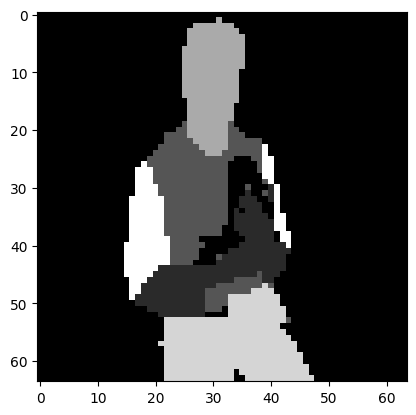

In [9]:
root_path = 'hierarchical_semantic_segmentation/Pascal-part'
dataset = SegmentationDataset(root_path=root_path, split='train', resize_shape=(64,64))
# dataset = SegmentationDataset(root_path=root_path, split='train')
print(dataset.__len__())

plt.imshow(dataset[2][1],cmap='gray')


# Training

In [3]:
def train_one_epoch(model, loader, optim, device):
    model.train()
    epoch_loss = 0.0
    for imgs, gts in tqdm(loader, desc="train", leave=False):
        imgs = imgs.to(device, non_blocking=True)
        gts =  gts.to(device, non_blocking=True)
        
        logits, _ = model(imgs)

        loss = hierarchical_losses(logits, gts)
        loss = loss[0]

        optim.zero_grad(set_to_none=True)
        loss.backward()
        optim.step()

        epoch_loss += loss.item() * imgs.size(0)
    return epoch_loss / len(loader.dataset)


def evaluate(model: nn.Module, loader: DataLoader, device: torch.device):
    model.eval()
    levels = [[1, 2, 3, 4, 5, 6],[1,6,2,4],[3,5],[1],[6],[2],[4],[3],[5]]
    tot = {k: 0.0 for k in range(len(levels))}

    val_loss = 0.0
    with torch.no_grad():
        for imgs, gts in tqdm(loader, desc="eval", leave=False):
            imgs, gts = imgs.to(device, non_blocking=True), gts.to(device, non_blocking=True)
            logits, _ = model(imgs)
            for lvl, cls_ids in enumerate(levels):
                tot[lvl] += compute_mIoU(logits, gts, cls_ids) * imgs.size(0)
            

            loss = hierarchical_losses(logits, gts)
            loss = loss[0]

            val_loss += loss.item() * imgs.size(0)

    return val_loss/len(loader.dataset), {f"mIoU^{lvl}": tot[lvl] / len(loader.dataset) for lvl in range(len(levels))}

def _prepare_level_target(gt: torch.Tensor, cls_ids: list[int]) -> torch.Tensor:
    remapped = torch.full_like(gt, 255)
    for new_idx, cid in enumerate(cls_ids):
        remapped[gt == cid] = new_idx
    return remapped


def hierarchical_losses(pred, gt):
    """Compute CE loss at each hierarchy level.

    Args:
        pred: (B, 9, H, W) logits from U²‑Net (no background channel).
        gt:   (B, H, W) ground‑truth with class IDs incl. background.
    Returns:
        List with three scalar losses [loss0, loss1, loss2].
    """
    losses = []
    levels = [[1, 2, 3, 4, 5, 6],[1,6,2,4],[3,5],[1],[6],[2],[4],[3],[5]]
    

    for cls_ids in levels:
        tgt = _prepare_level_target(gt, cls_ids)            # (B, H, W)
        logits = pred[:, cls_ids, :, :]                     # (B, K, H, W)
        losses.append(F.cross_entropy(logits, tgt, ignore_index=255))
    return losses


def compute_mIoU(pred: torch.Tensor, gt: torch.Tensor, cls_ids: list[int]) -> float:
    """Mean IoU for given *cls_ids*, ignoring background.

    Args:
        pred: (B, 9, H, W) logits.
        gt:   (B, H, W) labels.
    """
    with torch.no_grad():
        preds = pred.argmax(dim=1)  # (B, H, W)
        ious = []
        for cid in cls_ids:
            pred_mask = preds == cid
            true_mask = gt == cid
            intersection = (pred_mask & true_mask).sum().item()
            union = (pred_mask | true_mask).sum().item()
            if union == 0:
                continue  # class absent in both → skip from mean
            ious.append(intersection / union)
        return float(sum(ious) / max(len(ious), 1))

In [4]:
model = U2Net_Hierarchical(num_classes=7)
# x = torch.randn(2, 3, 128, 128)
# x = torch.randn(2, 3, 100, 100)
x = torch.randn(2, 3, 64, 64)

with torch.no_grad():
    y, sides = model(x)

print(y.shape)

torch.Size([2, 7, 64, 64])


In [5]:
#path to dataset root
root_path = 'hierarchical_semantic_segmentation/Pascal-part'
#path to save checkpoints
save = "hierarchical_semantic_segmentation/checkpoints"

epochs = 100
batch =64
lr = 1e-3
# device='cpu'
device='cuda'

resize_shape = (128,128)
# resize_shape = (100,100)
# resize_shape = (64,64)

# Model
model = U2Net_Hierarchical(num_classes=9).to(device)

# Data
train_ds = SegmentationDataset(root_path, split="train",resize_shape=resize_shape)
val_ds = SegmentationDataset(root_path, split="val",resize_shape=resize_shape)

train_loader = DataLoader(train_ds, batch_size=batch, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=batch, shuffle=False, num_workers=4, pin_memory=True)

# Optimiser
optim = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
lr_sched = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=epochs)

save_dir = Path(save); save_dir.mkdir(parents=True, exist_ok=True)



In [6]:
def round_value(val):
    if isinstance(val, tuple):
        return tuple(round(x, 3) for x in val)
    return round(val, 3)

for epoch in tqdm(range(1, epochs + 1)):
    train_loss = train_one_epoch(model, train_loader, optim, device)
    
    val_loss, metrics = evaluate(model, val_loader, device)
    
    lr_sched.step()

    result = {
    'mIoU0': metrics['mIoU^0']/6,
    'mIoU^1': (metrics['mIoU^1'] + metrics['mIoU^6'] + metrics['mIoU^2'] + metrics['mIoU^4']/4,
               metrics['mIoU^4'] + metrics['mIoU^5']/2),

    'mIoU^2': (metrics['mIoU^1'], metrics['mIoU^6'], metrics['mIoU^2'],  
              metrics['mIoU^4'], metrics['mIoU^3'], metrics['mIoU^5'])
              }
    
    result = {k: round_value(v) for k, v in result.items()}

    # Logging
    print(f"Epoch {epoch:03d} | loss={train_loss:.4f} | val_loss={val_loss:.4f} | metrics={result}")

    # Save checkpoint
    torch.save({
        "model": model.state_dict(),
        "optim": optim.state_dict(),
        "epoch": epoch,
    }, save_dir / f"checkpoint_{epoch:05d}.pth")



  0%|          | 0/100 [00:00<?, ?it/s]

train:   0%|          | 0/45 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 001 | loss=1.3867 | val_loss=4.7356 | metrics={'mIoU0': 0.01, 'mIoU^1': (0.202, 0.084), 'mIoU^2': (0.073, 0.095, 0.027, 0.027, 0.053, 0.115)}


train:   0%|          | 0/45 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 002 | loss=1.3135 | val_loss=1.3175 | metrics={'mIoU0': 0.01, 'mIoU^1': (0.215, 0.066), 'mIoU^2': (0.079, 0.11, 0.023, 0.008, 0.082, 0.117)}


train:   0%|          | 0/45 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 003 | loss=1.2457 | val_loss=1.2662 | metrics={'mIoU0': 0.013, 'mIoU^1': (0.279, 0.074), 'mIoU^2': (0.096, 0.132, 0.048, 0.013, 0.116, 0.123)}


train:   0%|          | 0/45 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 004 | loss=1.2020 | val_loss=1.3488 | metrics={'mIoU0': 0.013, 'mIoU^1': (0.305, 0.065), 'mIoU^2': (0.091, 0.149, 0.06, 0.021, 0.104, 0.087)}


train:   0%|          | 0/45 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 005 | loss=1.1875 | val_loss=1.1765 | metrics={'mIoU0': 0.016, 'mIoU^1': (0.309, 0.112), 'mIoU^2': (0.112, 0.125, 0.061, 0.046, 0.147, 0.132)}


train:   0%|          | 0/45 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 006 | loss=1.1502 | val_loss=1.2472 | metrics={'mIoU0': 0.015, 'mIoU^1': (0.309, 0.097), 'mIoU^2': (0.106, 0.133, 0.06, 0.041, 0.137, 0.112)}


train:   0%|          | 0/45 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 007 | loss=1.1138 | val_loss=1.1778 | metrics={'mIoU0': 0.016, 'mIoU^1': (0.299, 0.123), 'mIoU^2': (0.113, 0.108, 0.064, 0.054, 0.152, 0.139)}


train:   0%|          | 0/45 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 008 | loss=1.0669 | val_loss=1.0999 | metrics={'mIoU0': 0.017, 'mIoU^1': (0.349, 0.111), 'mIoU^2': (0.116, 0.153, 0.068, 0.048, 0.137, 0.127)}


train:   0%|          | 0/45 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 009 | loss=1.0583 | val_loss=1.1502 | metrics={'mIoU0': 0.015, 'mIoU^1': (0.29, 0.115), 'mIoU^2': (0.103, 0.119, 0.058, 0.038, 0.101, 0.154)}


train:   0%|          | 0/45 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 010 | loss=1.0132 | val_loss=1.0906 | metrics={'mIoU0': 0.018, 'mIoU^1': (0.346, 0.168), 'mIoU^2': (0.128, 0.131, 0.065, 0.091, 0.134, 0.154)}


train:   0%|          | 0/45 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 011 | loss=0.9915 | val_loss=1.1849 | metrics={'mIoU0': 0.015, 'mIoU^1': (0.31, 0.12), 'mIoU^2': (0.099, 0.132, 0.065, 0.054, 0.079, 0.132)}


train:   0%|          | 0/45 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 012 | loss=0.9898 | val_loss=1.0602 | metrics={'mIoU0': 0.017, 'mIoU^1': (0.336, 0.123), 'mIoU^2': (0.111, 0.134, 0.076, 0.056, 0.121, 0.134)}


train:   0%|          | 0/45 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 013 | loss=0.9217 | val_loss=1.0680 | metrics={'mIoU0': 0.017, 'mIoU^1': (0.354, 0.165), 'mIoU^2': (0.124, 0.14, 0.066, 0.096, 0.12, 0.137)}


train:   0%|          | 0/45 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 014 | loss=0.9112 | val_loss=1.0721 | metrics={'mIoU0': 0.017, 'mIoU^1': (0.337, 0.174), 'mIoU^2': (0.121, 0.132, 0.062, 0.086, 0.091, 0.174)}


train:   0%|          | 0/45 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 015 | loss=0.9239 | val_loss=1.0550 | metrics={'mIoU0': 0.018, 'mIoU^1': (0.384, 0.144), 'mIoU^2': (0.129, 0.178, 0.058, 0.074, 0.123, 0.142)}


train:   0%|          | 0/45 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 016 | loss=0.8676 | val_loss=1.1235 | metrics={'mIoU0': 0.017, 'mIoU^1': (0.354, 0.129), 'mIoU^2': (0.122, 0.155, 0.062, 0.059, 0.136, 0.14)}


train:   0%|          | 0/45 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [7]:
def visualize_predictions(model, test_loader, device, num_images=4):
    """
    Visualize model predictions on test images
    
    Args:
        model: Trained model
        test_loader: Test DataLoader
        device: Device (cuda/cpu)
        num_images: Number of images to visualize
    """
    model.eval()
    
    # Get a batch of test data
    images, labels = next(iter(test_loader))
    images = images[:num_images]
    labels = labels[:num_images]
    
    # Move to device and predict
    with torch.no_grad():
        images = images.to(device)
        logits, _ = model(images)
        preds = logits.argmax(dim=1).cpu().numpy()
    
    # Convert images and labels to numpy
    images = images.cpu().numpy()
    labels = labels.cpu().numpy()
    
    # Create figure
    fig, axes = plt.subplots(num_images, 3, figsize=(8, 3*num_images))
    if num_images == 1:
        axes = axes[np.newaxis, :]
    
    # Define class names for visualization (modify according to your classes)
    class_names = {
        0: "Background",
        1: "Class1",
        2: "Class2",
        3: "Class3",
        4: "Class4",
        5: "Class5",
        6: "Class6",
        7: "Class7",
        8: "Class8"
    }
    
    for i in range(num_images):
        # Original image
        img = np.transpose(images[i], (1, 2, 0))  # CHW to HWC
        img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0,1]
        
        # Ground truth
        gt = labels[i]
        
        # Prediction
        pred = preds[i]
        
        # Plot
        axes[i, 0].imshow(img)
        axes[i, 0].set_title("Input Image")
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(gt, cmap='jet', vmin=0, vmax=8)
        axes[i, 1].set_title("Ground Truth")
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(pred, cmap='jet', vmin=0, vmax=8)
        axes[i, 2].set_title("Prediction")
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

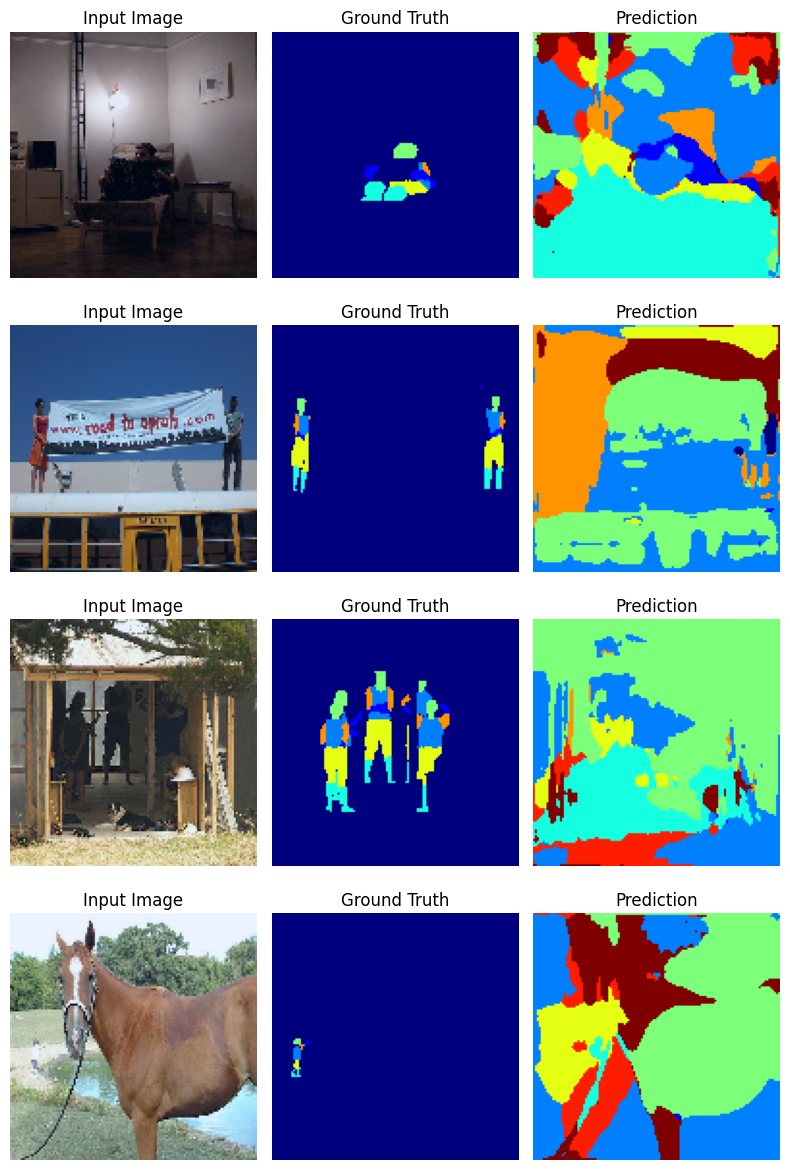

In [8]:
#path to dataset root
root_path = 'hierarchical_semantic_segmentation/Pascal-part'
#path to save checkpoints

# device='cpu'
device='cuda'

resize_shape = (128,128)
# resize_shape = (64,64)

val_ds = SegmentationDataset(root_path, split="val",resize_shape=resize_shape)
val_loader = DataLoader(val_ds, batch_size=batch, shuffle=False, num_workers=4, pin_memory=True)


visualize_predictions(model, val_loader, device, num_images=4)